<a href="https://colab.research.google.com/github/nilay2/FinancialCalculator/blob/master/ecg_signals_nilaytopcu_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install wfdb
import os
import wfdb
import subprocess #for better error handling


def download_physionet_database(database_name, target_dir):
    """Downloads a PhysioNet database and handles potential errors."""
    try:
        os.makedirs(target_dir, exist_ok=True)  # Create directory if it doesn't exist
        wfdb.dl_database(database_name, dl_dir=target_dir)
        print(f"Successfully downloaded {database_name} to {target_dir}")
        return True
    except Exception as e:
        print(f"Error downloading {database_name}: {e}")
        return False


def list_downloaded_files(directory):
  """Lists .dat files in a directory."""
  try:
      files = [os.path.splitext(f)[0] for f in os.listdir(directory) if f.endswith('.dat')]
      return files
  except FileNotFoundError:
      print(f"Error: Directory '{directory}' not found.")
      return []


# Check if wfdb is already installed
try:
    import wfdb
except ImportError:
    subprocess.check_call(['pip', 'install', 'wfdb']) #install wfdb if not installed


# List available PhysioNet databases (optional)
dbs = wfdb.get_dbs()
print("Available PhysioNet databases:\n", dbs)


# Specify database name and target directory
database_name = 'svdb'
target_directory = os.path.join(os.getcwd(), 'svdb_data')


# Download the database
if download_physionet_database(database_name, target_directory):
    # List downloaded files
    downloaded_files = list_downloaded_files(target_directory)
    print("\nDownloaded files:", downloaded_files)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 3.1 MB/s eta 0:00:00
Available PhysioNet databases:
 [['aami-ec13', 'ANSI/AAMI EC13 Test Waveforms'], ['accelerometry-walk-climb-drive', 'Labeled raw accelerometry data captured during walking, stair climbing and driving'], ['actes-cycloergometer-exercise', 'Cardiorespiratory measurement from graded cycloergometer exercise testing'], ['adfecgdb', 'Abdominal and Direct Fetal ECG Database'], ['afdb', 'MIT-BIH Atrial Fibrillation Database'], ['afpdb', 'PAF Prediction Challenge Database'], ['aftdb', 'AF Termination Challenge Database'], ['ahadb', 'AHA Database Sample Excluded Record'], ['ann-pt-summ', 'Medical Expert Annotations of Unsupported Facts in Doctor-Written and LLM-Generated Patient Summaries'], ['annotation-dataset-sdoh', 'Annotation dataset of social determinants of health from MIMIC-III Clinical Care Database'], ['annotation-dataset-sdoh', 'Annotation dataset of social determinants of health from MIMIC-III Clinical Car

In [4]:
import os
import numpy as np
import wfdb
from sklearn.utils import shuffle

# ... (load_and_preprocess_svdb function remains the same) ...

# Experiment with different time window sizes
time_window_sizes = [24, 48, 96, 192] # Example window sizes. You can adjust these

for time_window_size in time_window_sizes:
    print(f"\nProcessing with time window size: {time_window_size}")
    all_beats, all_annotations = load_and_preprocess_svdb('svdb_data', time_window_size)
    print(f"Shape of all_beats: {all_beats.shape}")
    print(f"Shape of all_annotations: {all_annotations.shape}")
    print('Number of N beats:', np.count_nonzero(all_annotations == 'N'))
    print('Number of S beats:', np.count_nonzero(all_annotations == 'S'))
    print('Number of V beats:', np.count_nonzero(all_annotations == 'V'))


Processing with time window size: 24
Shape of all_beats: (183707, 48)
Shape of all_annotations: (183707,)
Number of N beats: 161653
Number of S beats: 12146
Number of V beats: 9908

Processing with time window size: 48
Shape of all_beats: (183707, 96)
Shape of all_annotations: (183707,)
Number of N beats: 161653
Number of S beats: 12146
Number of V beats: 9908

Processing with time window size: 96
Shape of all_beats: (183707, 192)
Shape of all_annotations: (183707,)
Number of N beats: 161653
Number of S beats: 12146
Number of V beats: 9908

Processing with time window size: 192
Shape of all_beats: (183707, 384)
Shape of all_annotations: (183707,)
Number of N beats: 161653
Number of S beats: 12146
Number of V beats: 9908


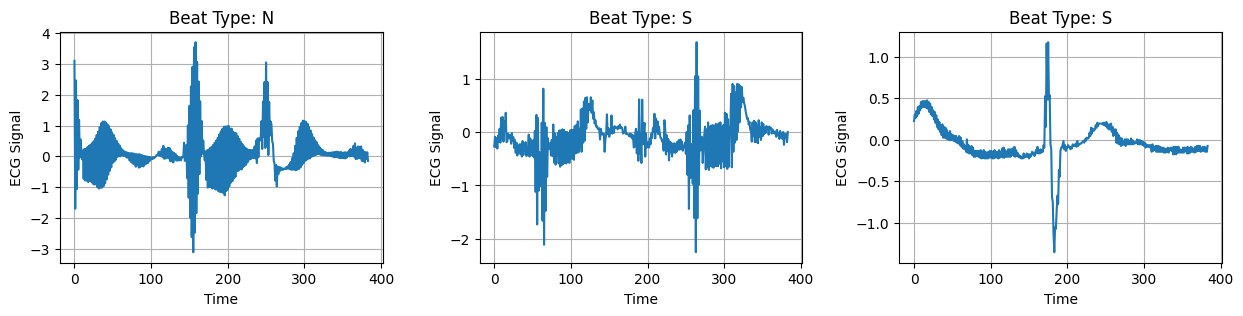

In [5]:
import matplotlib.pyplot as plt

def plot_ecg_beats(beats, annotations, sample_numbers):
    """Plots ECG beat segments with annotations.  Handles potential errors."""
    num_plots = len(sample_numbers)
    fig, axes = plt.subplots(1, num_plots, figsize=(15, 3))
    plt.subplots_adjust(wspace=0.3)  # Adjust spacing for better readability

    for i, sample_index in enumerate(sample_numbers):
        try:
            ax = axes[i]
            ax.plot(beats[sample_index])
            ax.set(xlabel='Time', ylabel='ECG Signal', title=f'Beat Type: {annotations[sample_index]}')
            ax.grid(True)  # Add grid for better visualization
        except IndexError:
            print(f"Warning: Sample index {sample_index} is out of bounds. Skipping.")
        except Exception as e:
            print(f"An error occurred while plotting sample {sample_index}: {e}")


# Example usage:
sample_numbers = [200, 299, 996]  # Example sample indices. Adjust as needed.

#Check if sample_numbers are within the range
if np.max(sample_numbers) >= len(all_beats) or np.min(sample_numbers) < 0:
  print("Warning: One or more sample numbers are out of range.")
else:
  plot_ecg_beats(all_beats, all_annotations, sample_numbers)
  plt.show()

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def preprocess_and_split_data(X, y, test_size=0.15, val_size=0.15):
    """Preprocesses and splits the data into training, validation, and testing sets."""
    X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=test_size, random_state=42)
    val_size_ratio = val_size / (1 - test_size)
    X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=val_size_ratio, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)  # Apply the same scaler to validation and test sets
    X_test = scaler.transform(X_test)

    return X_train, X_val, X_test, y_train, y_val, y_test


def calculate_accuracy(y_pred, y_true, comment="", printout=True):
    """Calculates total and arrhythmia accuracy."""
    total_accuracy = np.mean(y_pred == y_true)
    arrhythmia_indices = np.where(y_true != 'N')[0]
    arrhythmia_accuracy = np.mean(y_pred[arrhythmia_indices] == y_true[arrhythmia_indices]) if len(arrhythmia_indices) > 0 else 0

    if printout:
        print("-----------------------------------")
        print(comment)
        print(f"Total Accuracy (Acc_T): {total_accuracy:.4f}")
        print(f"Arrhythmia Accuracy (Acc_A): {arrhythmia_accuracy:.4f}")
        print("-----------------------------------")
    else:
        return total_accuracy, arrhythmia_accuracy


# Example usage (assuming 'all_beats' and 'all_annotations' are defined):
X, y = all_beats[::5], all_annotations[::5]  # Subsample data
X_train, X_val, X_test, y_train, y_val, y_test = preprocess_and_split_data(X, y)

print(f"Training set size: {len(y_train)}")
print(f"Validation set size: {len(y_val)}")
print(f"Test set size: {len(y_test)}")

Training set size: 31230
Validation set size: 4539
Test set size: 973



Evaluating: Gaussian Naive Bayes
              precision    recall  f1-score   support

           N       0.89      0.70      0.79       849
           S       0.06      0.06      0.06        71
           V       0.10      0.43      0.16        53

    accuracy                           0.64       973
   macro avg       0.35      0.40      0.33       973
weighted avg       0.79      0.64      0.70       973



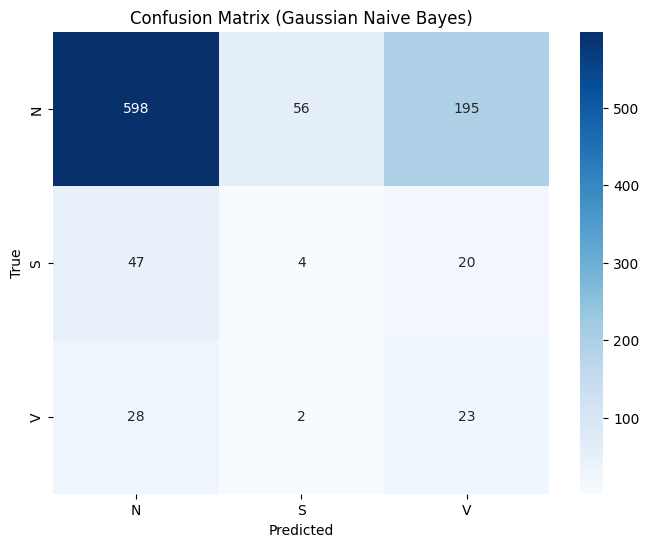


Evaluating: SVM


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           N       0.87      1.00      0.93       849
           S       0.00      0.00      0.00        71
           V       0.00      0.00      0.00        53

    accuracy                           0.87       973
   macro avg       0.29      0.33      0.31       973
weighted avg       0.76      0.87      0.81       973



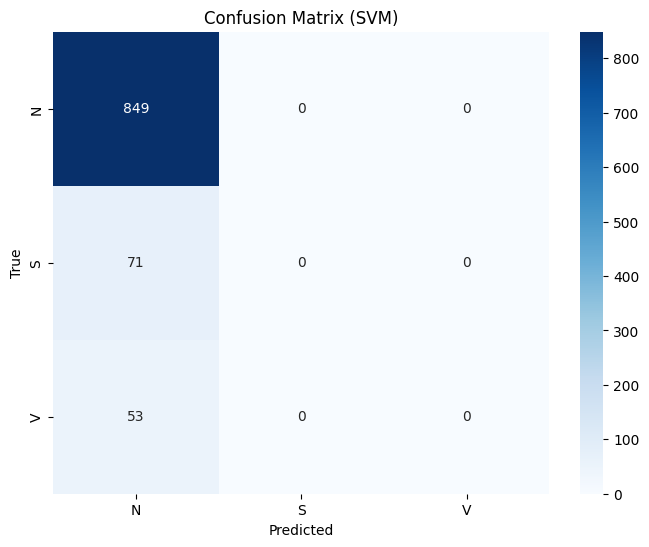


Evaluating: SVM (Balanced)
              precision    recall  f1-score   support

           N       0.88      0.84      0.86       849
           S       0.15      0.21      0.18        71
           V       0.10      0.13      0.11        53

    accuracy                           0.75       973
   macro avg       0.38      0.39      0.38       973
weighted avg       0.79      0.75      0.77       973



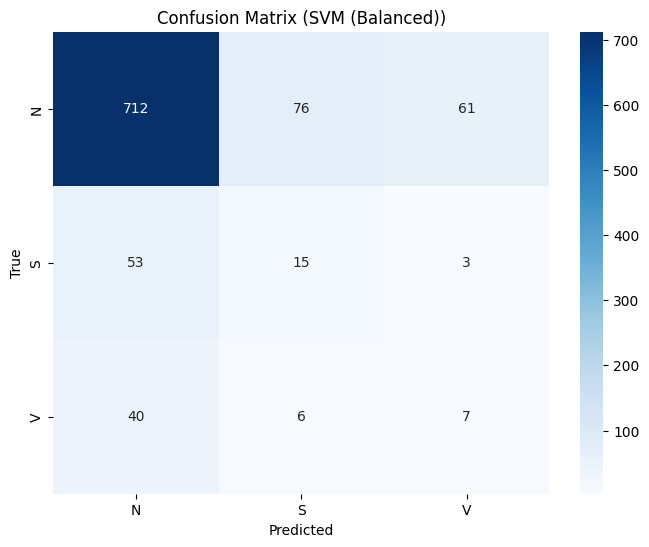

In [7]:
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


def evaluate_classifier(model, X_test, y_test, model_name):
    """Evaluates a classifier and prints a classification report and confusion matrix."""
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['N', 'S', 'V'], yticklabels=['N', 'S', 'V'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix ({model_name})')
    plt.show()

# Train and evaluate classifiers
classifiers = {
    'Gaussian Naive Bayes': GaussianNB(),
    'SVM': svm.SVC(),
    'SVM (Balanced)': svm.SVC(class_weight='balanced')
}

for name, classifier in classifiers.items():
    print(f"\nEvaluating: {name}")
    classifier.fit(X_train, y_train)
    evaluate_classifier(classifier, X_test, y_test, name)

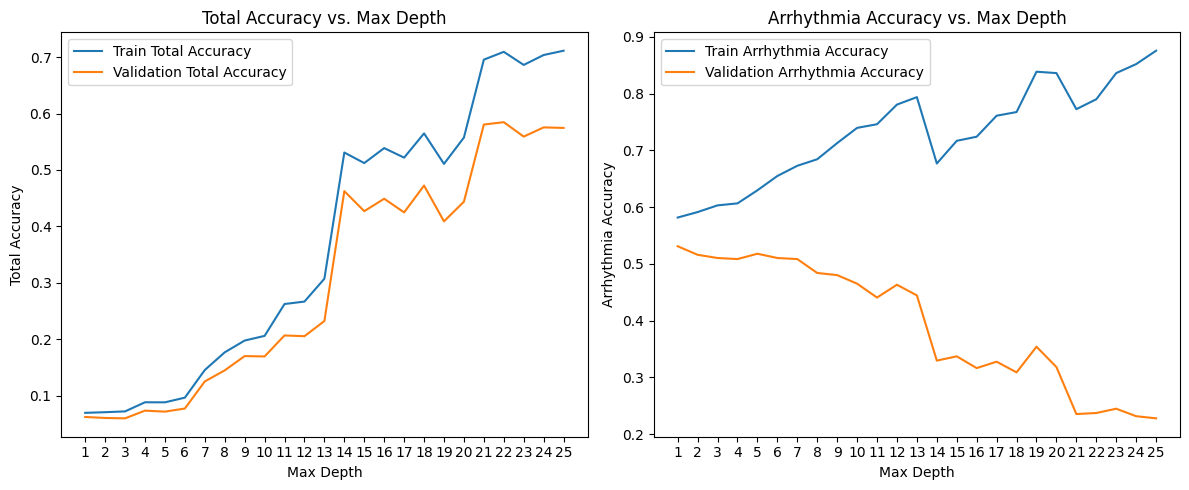


Decision Tree evaluation with max_depth = 1:
              precision    recall  f1-score   support

           N       0.00      0.00      0.00       849
           S       0.07      0.82      0.13        71
           V       0.09      0.32      0.15        53

    accuracy                           0.08       973
   macro avg       0.06      0.38      0.09       973
weighted avg       0.01      0.08      0.02       973



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


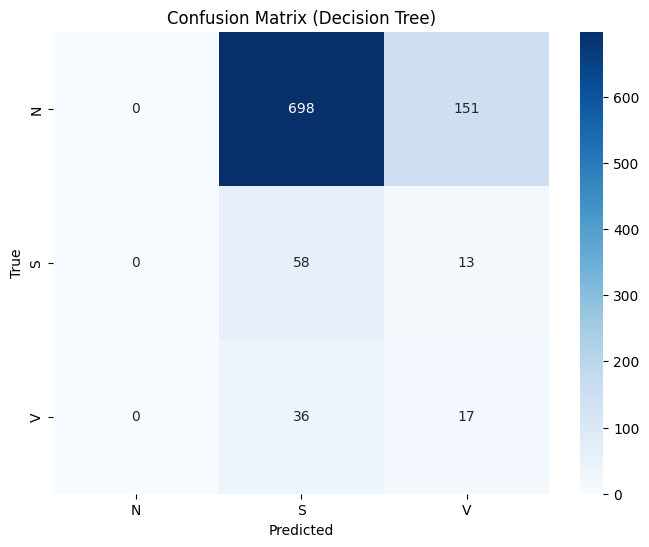

In [8]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


def evaluate_and_plot_dt(X_train, y_train, X_val, y_val, X_test, y_test, max_depth_values):

    train_acc_t = []
    train_acc_a = []
    val_acc_t = []
    val_acc_a = []

    for max_depth in max_depth_values:
        dtc = DecisionTreeClassifier(criterion='entropy', class_weight='balanced', min_samples_leaf=10, max_depth=max_depth)
        dt_fit = dtc.fit(X_train, y_train)
        y_pred_train = dt_fit.predict(X_train)
        y_pred_val = dt_fit.predict(X_val)
        acc_t_train, acc_a_train = calculate_accuracy(y_pred_train, y_train, printout=False)
        acc_t_val, acc_a_val = calculate_accuracy(y_pred_val, y_val, printout=False)
        train_acc_t.append(acc_t_train)
        train_acc_a.append(acc_a_train)
        val_acc_t.append(acc_t_val)
        val_acc_a.append(acc_a_val)

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].plot(max_depth_values, train_acc_t, label='Train Total Accuracy')
    axes[0].plot(max_depth_values, val_acc_t, label='Validation Total Accuracy')
    axes[0].set(xlabel='Max Depth', ylabel='Total Accuracy', title='Total Accuracy vs. Max Depth')
    axes[0].legend()
    axes[0].xaxis.set_ticks(max_depth_values)

    axes[1].plot(max_depth_values, train_acc_a, label='Train Arrhythmia Accuracy')
    axes[1].plot(max_depth_values, val_acc_a, label='Validation Arrhythmia Accuracy')
    axes[1].set(xlabel='Max Depth', ylabel='Arrhythmia Accuracy', title='Arrhythmia Accuracy vs. Max Depth')
    axes[1].legend()
    axes[1].xaxis.set_ticks(max_depth_values)


    plt.tight_layout()
    plt.show()

    #Evaluate on test set with best max_depth
    best_max_depth = max_depth_values[np.argmax(val_acc_a)]
    best_dtc = DecisionTreeClassifier(criterion='entropy', class_weight='balanced', min_samples_leaf=10, max_depth=best_max_depth)
    best_dtc.fit(X_train, y_train)
    print(f"\nDecision Tree evaluation with max_depth = {best_max_depth}:")
    evaluate_classifier(best_dtc, X_test, y_test, "Decision Tree")


# Example usage:
max_depth_values = range(1, 26)  #Range of max_depth values to test
evaluate_and_plot_dt(X_train, y_train, X_val, y_val, X_test, y_test, max_depth_values)


Evaluating: Decision Tree (Acc_A Maximized)
              precision    recall  f1-score   support

           N       0.86      0.08      0.15       849
           S       0.07      0.66      0.13        71
           V       0.10      0.45      0.16        53

    accuracy                           0.14       973
   macro avg       0.34      0.40      0.15       973
weighted avg       0.76      0.14      0.15       973



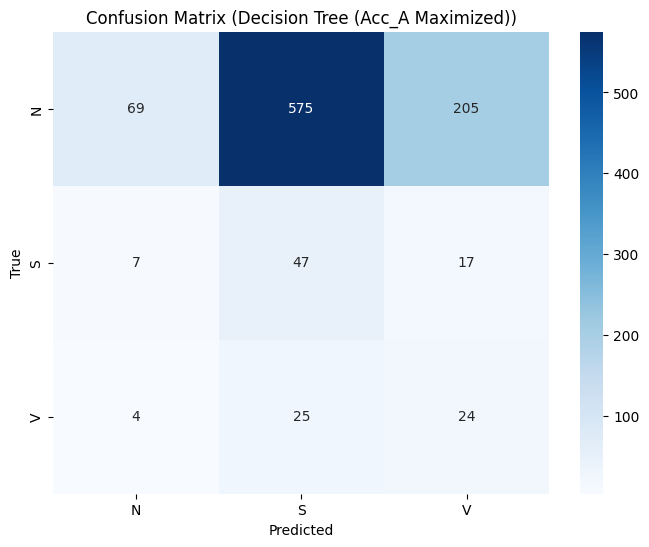


Evaluating: Decision Tree (Acc_T + Acc_A Maximized)
              precision    recall  f1-score   support

           N       0.85      0.20      0.32       849
           S       0.07      0.62      0.12        71
           V       0.07      0.17      0.09        53

    accuracy                           0.23       973
   macro avg       0.33      0.33      0.18       973
weighted avg       0.75      0.23      0.30       973



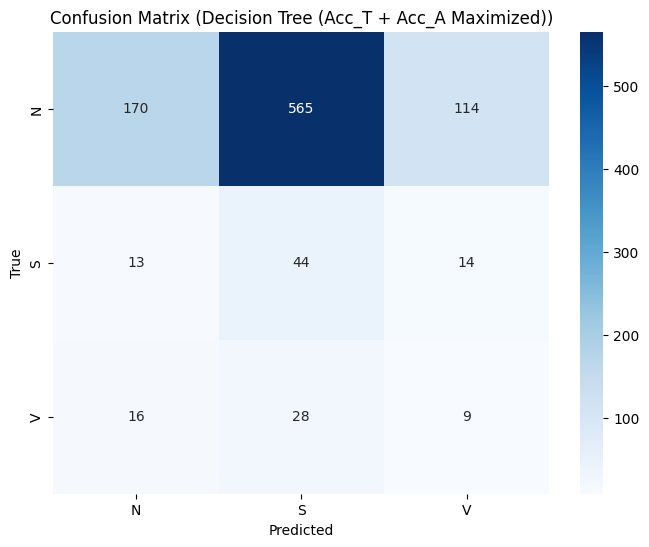

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


def evaluate_classifier(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['N', 'S', 'V'], yticklabels=['N', 'S', 'V'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix ({model_name})')
    plt.show()


# Define classifiers
dtc_acc_a = DecisionTreeClassifier(criterion='entropy', class_weight='balanced', min_samples_leaf=10, max_depth=8)
dtc_acc_t_a = DecisionTreeClassifier(criterion='entropy', class_weight='balanced', min_samples_leaf=10, max_depth=13)

# Train and evaluate
classifiers = {
    'Decision Tree (Acc_A Maximized)': dtc_acc_a,
    'Decision Tree (Acc_T + Acc_A Maximized)': dtc_acc_t_a
}

for name, classifier in classifiers.items():
    print(f"\nEvaluating: {name}")
    classifier.fit(X_train, y_train)
    evaluate_classifier(classifier, X_test, y_test, name)


Decision Tree with PCA:
              precision    recall  f1-score   support

           N       0.90      0.58      0.71       849
           S       0.12      0.24      0.16        71
           V       0.08      0.45      0.14        53

    accuracy                           0.55       973
   macro avg       0.37      0.43      0.34       973
weighted avg       0.80      0.55      0.64       973



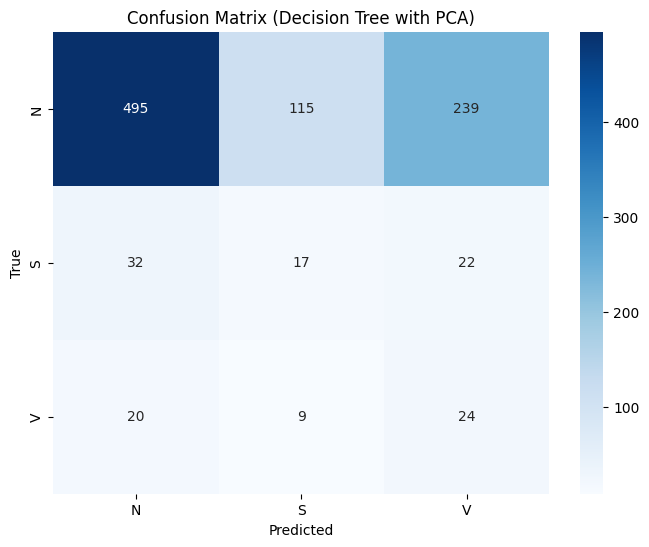

In [10]:
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


def evaluate_classifier(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['N', 'S', 'V'], yticklabels=['N', 'S', 'V'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix ({model_name})')
    plt.show()


# PCA with improved handling
def apply_pca(X_train, X_test, n_components):
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)  # Apply the same transformation to the test set
    return X_train_pca, X_test_pca


# Apply PCA
n_components = 15
X_train_pca, X_test_pca = apply_pca(X_train, X_test, n_components)

# Train and evaluate Decision Tree with PCA
dtc_pca = DecisionTreeClassifier(criterion='entropy', class_weight='balanced', min_samples_leaf=5, max_depth=8)
dtc_pca.fit(X_train_pca, y_train)
print("\nDecision Tree with PCA:")
evaluate_classifier(dtc_pca, X_test_pca, y_test, 'Decision Tree with PCA')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 26.4 MB/s eta 0:00:00

Evaluating: Decision Tree
              precision    recall  f1-score   support

           N       0.90      0.25      0.39       849
           S       0.08      0.41      0.13        71
           V       0.07      0.45      0.11        53

    accuracy                           0.27       973
   macro avg       0.35      0.37      0.21       973
weighted avg       0.79      0.27      0.35       973



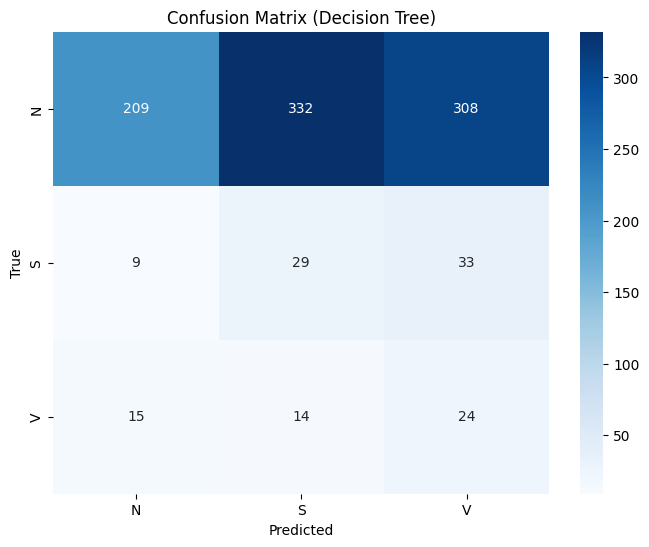


Evaluating: Random Forest
              precision    recall  f1-score   support

           N       0.88      0.84      0.86       849
           S       0.13      0.20      0.16        71
           V       0.07      0.08      0.07        53

    accuracy                           0.75       973
   macro avg       0.36      0.37      0.36       973
weighted avg       0.78      0.75      0.76       973



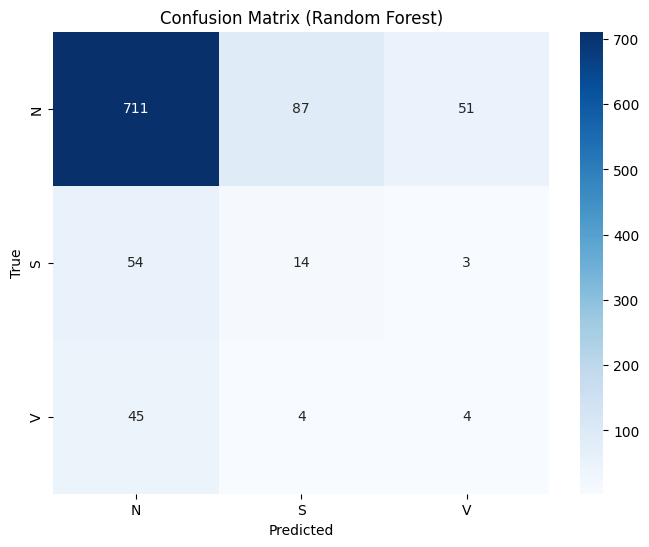


Evaluating: AdaBoost


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           N       0.87      1.00      0.93       849
           S       0.33      0.01      0.03        71
           V       0.00      0.00      0.00        53

    accuracy                           0.87       973
   macro avg       0.40      0.34      0.32       973
weighted avg       0.79      0.87      0.82       973



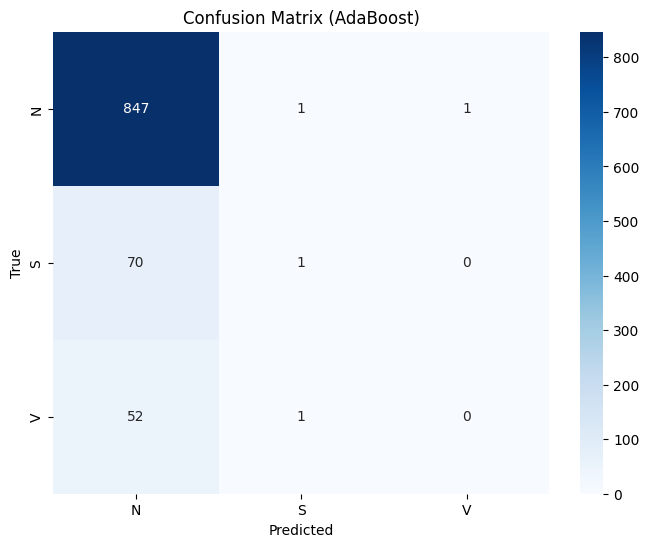

In [12]:

!pip install PyWavelets
import pywt # import pywt instead of pwyt

import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


def evaluate_classifier(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['N', 'S', 'V'], yticklabels=['N', 'S', 'V'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix ({model_name})')
    plt.show()



def extract_features(input_sample):
    """Extracts features using wavelet transforms and simple differences."""
    wavelets = ['sym8', 'db6', 'db9', 'dmey']
    level = 4
    features = []

    for wavelet in wavelets:
        cA = pywt.downcoef('a', input_sample, wavelet, level=level, mode='per')
        cD = pywt.downcoef('d', input_sample, wavelet, level=level, mode='per')
        features.extend(cA)
        features.extend(cD)

    # Simple differences
    differences = [input_sample[t + 1] - input_sample[t] for t in range(40, 55)] #Reduced range to avoid errors.
    features.extend(differences)

    return np.array(features)


def data_features(input_data):
    """Applies feature extraction to a dataset."""
    return np.array([extract_features(sample) for sample in input_data])


# Feature Extraction
X_train_features = data_features(X_train)
X_test_features = data_features(X_test)

# Model Training and Evaluation

classifiers = {
    'Decision Tree': DecisionTreeClassifier(criterion='entropy', class_weight='balanced', min_samples_leaf=10, max_depth=8),
    'Random Forest': RandomForestClassifier(criterion='entropy', n_estimators=1000, max_depth=8, class_weight='balanced', random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=200, random_state=42)
}


for name, classifier in classifiers.items():
    print(f"\nEvaluating: {name}")
    classifier.fit(X_train_features, y_train)
    evaluate_classifier(classifier, X_test_features, y_test, name)